In [30]:
import os
from copy import deepcopy
import cv2
import json
import math
import spacy
import numpy as np
import pandas as pd
from collections import defaultdict

annotations_json_file_path = f"{os.environ['CODE']}/scripts/07_reproduce_baseline_results/data/ego4d/ego4d_clip_annotations_v3.json"

with open(annotations_json_file_path, "r") as reader:
    annotations = json.load(reader)

nlp = spacy.load('en_core_web_lg')

def process_blip2_answers(blip2_answers):
    docs = [nlp(blip2_answer) for blip2_answer in blip2_answers]
    words = []
    for doc in docs:
        words.extend([token.lemma_.lower() for token in doc if (token.lemma_.isalpha()) and (not token.is_stop) and (token.text != "no_answer")])
    return words

action_category_blip2_answer_word_tfs = dict()
blip2_answer_word_dfs = dict()

def fill_missing_cells(df_group):
    df_group_sorted = df_group.sort_values(by="frame_index").reset_index(drop=False)
    delete_first_row = False
    for index, row in df_group_sorted.iterrows():
        if pd.isnull(row["answer"]):
            if index == 0:
                delete_first_row = True
            else:
                df_group_sorted.at[index, "answer"] = df_group_sorted.at[index - 1, "answer"]
    if delete_first_row:
        df_group_sorted = df_group_sorted.iloc[1:, :]
    return df_group_sorted

def get_fill_value(blip2_vqa_answers_df: pd.DataFrame, frame_index: int, question: str):
    blip2_vqa_row = blip2_vqa_answers_df[(blip2_vqa_answers_df["frame_index"] == frame_index - 6) & (blip2_vqa_answers_df["question"] == question)]
    if len(blip2_vqa_row) > 1:
        print(blip2_vqa_row)
        raise Exception("How can this be possible?")
    if len(blip2_vqa_row) == 1:
        return blip2_vqa_row["answer"]
    else:
        if frame_index == 0:
            return "no_answer"
        else:
            return get_fill_value(blip2_vqa_answers_df=blip2_vqa_answers_df, frame_index=frame_index - 6, question=question)



for clip_id in os.listdir(os.path.join(os.environ["SCRATCH"], "ego4d_data/v2/frame_features")):
    current_annotations = annotations[clip_id]["annotations"]
    if len(current_annotations) == 0:
        continue
    if not os.path.exists(os.path.join(os.environ["SCRATCH"], "ego4d_data/v2/frame_features/", clip_id, "blip2_vqa_features.tsv")):
        continue
    blip2_vqa_answers_df = pd.read_csv(os.path.join(os.environ["SCRATCH"], "ego4d_data/v2/frame_features/", clip_id, "blip2_vqa_features.tsv"), sep="\t")
    blip2_vqa_answers_df = blip2_vqa_answers_df.reset_index(drop=True)

    print(blip2_vqa_answers_df.shape, blip2_vqa_answers_df.drop_duplicates(subset=['frame_index', 'question']).shape)

    for index, row in blip2_vqa_answers_df.iterrows():
        if pd.isnull(row["answer"]):
            frame_index = row["frame_index"]
            question = row["question"]
            fill_value = get_fill_value(blip2_vqa_answers_df=blip2_vqa_answers_df, frame_index=frame_index, question=question)
            blip2_vqa_answers_df.iat[index, "answer"] = fill_value

    cap = cv2.VideoCapture(os.path.join(os.environ["SCRATCH"], "ego4d_data/v2/clips", clip_id + ".mp4"))
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()
    for frame_id in range(0, num_frames, 6):
        current_blip2_answers = blip2_vqa_answers_df[blip2_vqa_answers_df["frame_index"] == frame_id]
        current_blip2_happen_answer = current_blip2_answers[current_blip2_answers["question"] == "What is happening in this picture?"]["answer"].values[0]
        current_blip2_describe_answer = current_blip2_answers[current_blip2_answers["question"] == "What does the image describe?"]["answer"].values[0]
        current_blip2_do_answer = current_blip2_answers[current_blip2_answers["question"] == "What is the person in this picture doing?"]["answer"].values[0]
        blip2_answers = [current_blip2_happen_answer, current_blip2_describe_answer, current_blip2_do_answer]
        blip2_answer_words = process_blip2_answers(blip2_answers)

        for current_annotation in current_annotations:
            if frame_id / fps >= current_annotation["segment"][0] and frame_id / fps <= current_annotation["segment"][1]:
                for blip2_answer_word in blip2_answer_words:
                    if current_annotation["label"] not in action_category_blip2_answer_word_tfs.keys():
                        action_category_blip2_answer_word_tfs[current_annotation["label"]] = dict()
                        action_category_blip2_answer_word_tfs[current_annotation["label"]][blip2_answer_word] = 1
                    else:
                        if blip2_answer_word not in action_category_blip2_answer_word_tfs[current_annotation["label"]].keys():
                            action_category_blip2_answer_word_tfs[current_annotation["label"]][blip2_answer_word] = 1
                        else:
                            action_category_blip2_answer_word_tfs[current_annotation["label"]][blip2_answer_word] += 1
                    
                    if blip2_answer_word not in blip2_answer_word_dfs.keys():
                        blip2_answer_word_dfs[blip2_answer_word] = 1
                    else:
                        blip2_answer_word_dfs[blip2_answer_word] += 1

blip2_answer_word_idfs = dict()
for blip2_answer_word in blip2_answer_word_dfs.keys():
    blip2_answer_word_idfs[blip2_answer_word] += math.log(len(blip2_answer_word_dfs.keys()) / (1 + float(blip2_answer_word_dfs[blip2_answer_word])), 2)

action_category_blip2_word_tf_idfs = dict()
for action_category in action_category_blip2_answer_word_tfs.keys():
    action_category_blip2_word_tf_idfs[action_category] = dict()

    for blip2_answer_word in action_category_blip2_answer_word_tfs[action_category].keys():
        action_category_blip2_word_tf_idfs[action_category][blip2_answer_word] = action_category_blip2_answer_word_tfs[action_category][blip2_answer_word] * blip2_answer_word_idfs[blip2_answer_word]


(28806, 3) (7203, 3)
(13206, 3) (3303, 3)
      frame_index                       question  \
1056          528  What does the image describe?   
1068          528  What does the image describe?   
1080          528  What does the image describe?   
1092          528  What does the image describe?   

                                              answer  
1056  The image describes a car with a broken engine  
1068  The image describes a car with a broken engine  
1080  The image describes a car with a broken engine  
1092  The image describes a car with a broken engine  


Exception: How can this be possible?

In [43]:
clip_id

'011eb377-92f6-4820-9765-81d822c9a2a5'

In [44]:
blip2_vqa_answers_df["frame_index", "question"].values


KeyError: ('frame_index', 'question')

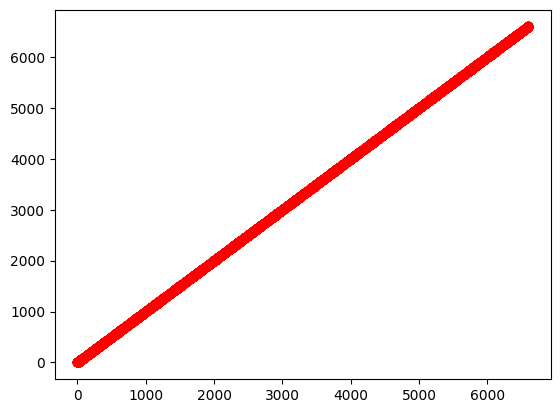

In [40]:
import matplotlib.pyplot as plt

plt.plot(np.sort(blip2_vqa_answers_df["frame_index"].values), np.sort(blip2_vqa_answers_df["frame_index"].values), marker="o", color="red")


In [1]:
import os
import cv2
import json

annotations_json_file_path = f"{os.environ['CODE']}/scripts/07_reproduce_baseline_results/data/ego4d/ego4d_clip_annotations_v3.json"
clip_id = "003c5ae8-3abd-4824-8efb-21a9a4f8eafe"

with open(annotations_json_file_path, "r") as reader:
    annotations = json.load(reader)[clip_id]["annotations"]


In [9]:
import os
import cv2
import json

annotations_json_file_path = f"{os.environ['CODE']}/scripts/07_reproduce_baseline_results/data/ego4d/ego4d_clip_annotations_v3.json"

with open(annotations_json_file_path, "r") as reader:
    annotations = json.load(reader)[clip_id]["annotations"]

cap = cv2.VideoCapture(os.path.join(os.environ["SCRATCH"], "ego4d_data/v2/clips", "003c5ae8-3abd-4824-8efb-21a9a4f8eafe.mp4"))
fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

for frame_id in range(num_frames):
    for annotations_dict




In [4]:
import os
import cv2
import json
import argparse
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import random
from dash import Dash, html, dcc, Input, Output, no_update

import sys

sys.path.append("../")

from utils import extract_frames

random.seed(1903)

ground_truth_asl_predicted_action_category_match_color_mapping = {
    True: "rgba(0, 255, 0, 1.0)",
    False: "rgba(255, 0, 0, 1.0)",
}

unique_action_categories = set(["background", "no_annotations_for_the_clip"])


def generate_random_color():
    random_int = np.random.randint(low=0, high=256, size=(3,))
    random_color = f"rgba({random_int[0]}, {random_int[1]}, {random_int[2]}, 1.0)"
    return random_color


def get_blip2_answer(current_blip2_rows, blip2_question):
    answer = current_blip2_rows[current_blip2_rows["question"] == blip2_question][
        "answer"
    ]
    if len(answer) == 0:
        return "NaN"
    else:
        return answer.values[0]


if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="Argument parser")
    parser.add_argument(
        "--clip_id",
        type=str,
        default="003c5ae8-3abd-4824-8efb-21a9a4f8eafe",
    )
    parser.add_argument(
        "--ground_truth_action_instances_file_path",
        type=str,
        default=f"{os.environ['CODE']}/scripts/07_reproduce_baseline_results/data/ego4d/ego4d_clip_annotations_v3.json",
    )
    parser.add_argument(
        "--asl_predicted_action_instances_file_path",
        type=str,
        default=f"{os.environ['CODE']}/scripts/07_reproduce_baseline_results/submission_final.json",
    )
    parser.add_argument(
        "--assets_path",
        type=str,
        default=f"{os.environ['SCRATCH']}/ego4d_data/v2/frames",
    )
    parser.add_argument("--frame_feature_extraction_stride", type=int, default=6)
    args = parser.parse_args()

    with open(
        os.path.join(
            os.environ["CODE"],
            "scripts/07_reproduce_baseline_results/data/ego4d/ego4d_clip_annotations_v3.json",
        ),
        "r",
    ) as reader:
        annotations_dict = json.load(reader)

    if (
        not os.path.exists(
            os.path.join(
                os.environ["SCRATCH"],
                "ego4d_data/v2/frames",
                args.clip_id,
                "end.txt",
            )
        )
        or not (len(annotations_dict[args.clip_id]["annotations"]) > 0)
        or not os.path.exists(
            os.path.join(
                os.environ["SCRATCH"],
                "ego4d_data/v2/frame_features",
                args.clip_id,
                "blip2_vqa_features.tsv",
            )
        )
    ):
        raise Exception("Please choose another clip.")

    ground_truth_action_instances = json.load(
        open(args.ground_truth_action_instances_file_path, "r")
    )[args.clip_id]["annotations"]
    asl_predicted_action_instances = json.load(
        open(args.asl_predicted_action_instances_file_path, "r")
    )["detect_results"][args.clip_id]
    blip2_answers_folder_path = os.path.join(
        os.environ["SCRATCH"], "ego4d_data/v2/frame_features", args.clip_id
    )
    blip2_answers_file_names = [
        file_name
        for file_name in os.listdir(blip2_answers_folder_path)
        if file_name.startswith("blip2_")
    ]
    blip2_answers_file_paths = [
        os.path.join(
            os.environ["SCRATCH"],
            "ego4d_data/v2/frame_features",
            args.clip_id,
            blip2_answers_file_name,
        )
        for blip2_answers_file_name in blip2_answers_file_names
    ]
    blip2_answers_dfs = pd.concat(
        [
            pd.read_csv(blip2_answers_file_path, sep="\t")
            for blip2_answers_file_path in blip2_answers_file_paths
        ],
        axis=0,
    )

    cap = cv2.VideoCapture(
        os.path.join(
            os.environ["SCRATCH"], "ego4d_data/v2/clips", args.clip_id + ".mp4"
        )
    )
    fps = cap.get(cv2.CAP_PROP_FPS)
    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    cap.release()

    extract_frames(clip_id=args.clip_id, output_folder_path=args.assets_path)

    frame_id_ground_truth_action_categories_mapping = {}
    frame_id_asl_predicted_action_categories_mapping = {}

    for current_frame_id in range(num_frames):
        frame_id_asl_predicted_action_categories_mapping[current_frame_id] = []
        current_frame_time = current_frame_id / fps
        assigned_to_an_action_category = False
        for asl_predicted_action_instance in asl_predicted_action_instances:
            if (
                current_frame_time >= asl_predicted_action_instance["segment"][0]
                and current_frame_time <= asl_predicted_action_instance["segment"][1]
            ):
                assigned_to_an_action_category = True
                frame_id_asl_predicted_action_categories_mapping[
                    current_frame_id
                ].append(
                    (
                        asl_predicted_action_instance["label"],
                        asl_predicted_action_instance["score"],
                    )
                )
                unique_action_categories.add(asl_predicted_action_instance["label"])
        if assigned_to_an_action_category:
            frame_id_asl_predicted_action_categories_mapping[current_frame_id] = sorted(
                frame_id_asl_predicted_action_categories_mapping[current_frame_id],
                key=lambda x: x[1],
            )[-1][0]
        else:
            frame_id_asl_predicted_action_categories_mapping[
                current_frame_id
            ] = "background"

        if len(ground_truth_action_instances) == 0:
            frame_id_ground_truth_action_categories_mapping[
                current_frame_id
            ] = "no_annotations_for_the_clip"
        else:
            assigned_to_an_action_category = False
            for ground_truth_action_instance in ground_truth_action_instances:
                if (
                    current_frame_time >= ground_truth_action_instance["segment"][0]
                    and current_frame_time <= ground_truth_action_instance["segment"][1]
                ):
                    assigned_to_an_action_category = True
                    frame_id_ground_truth_action_categories_mapping[
                        current_frame_id
                    ] = ground_truth_action_instance["label"]
                    unique_action_categories.add(ground_truth_action_instance["label"])
            if not assigned_to_an_action_category:
                frame_id_ground_truth_action_categories_mapping[
                    current_frame_id
                ] = "background"

    action_category_color_mapping = dict(
        (action_category, generate_random_color())
        for action_category in sorted(list(unique_action_categories))
    )

    sequences_dict = {
        "gt_colors": [],
        "asl_pred_colors": [],
        "match_colors": [],
        "gt_values": [],
        "asl_pred_values": [],
        "match_values": [],
        "frame_ids": [],
        "blip2_happen_answers": [],
        "blip2_do_answers": [],
        "blip2_describe_answers": [],
        "blip2_captioning_answers": [],
    }

    blip2_describe_question = "What does the image describe?"
    blip2_do_question = "What is the person in this picture doing?"
    blip2_happen_question = "What is happening in this picture?"
    blip2_captioning_question = "Image Caption"

    for frame_id in range(num_frames):
        current_blip2_rows = blip2_answers_dfs[
            blip2_answers_dfs["frame_index"]
            == (frame_id // args.frame_feature_extraction_stride)
            * args.frame_feature_extraction_stride
        ]
        current_blip2_describe_answer = get_blip2_answer(
            current_blip2_rows=current_blip2_rows,
            blip2_question=blip2_describe_question,
        )
        current_blip2_do_answer = get_blip2_answer(
            current_blip2_rows=current_blip2_rows, blip2_question=blip2_do_question
        )
        current_blip2_happen_answer = get_blip2_answer(
            current_blip2_rows=current_blip2_rows,
            blip2_question=blip2_happen_question,
        )
        current_blip2_captioning_answer = get_blip2_answer(
            current_blip2_rows=current_blip2_rows,
            blip2_question=blip2_captioning_question,
        )

        current_ground_truth_action_category = (
            frame_id_ground_truth_action_categories_mapping[frame_id]
        )
        sequences_dict["frame_ids"].append(frame_id)
        sequences_dict["gt_values"].append(current_ground_truth_action_category)
        current_ground_truth_action_category_color = action_category_color_mapping[
            current_ground_truth_action_category
        ]
        sequences_dict["gt_colors"].append(current_ground_truth_action_category_color)
        sequences_dict["blip2_happen_answers"].append(current_blip2_happen_answer)
        sequences_dict["blip2_do_answers"].append(current_blip2_do_answer)
        sequences_dict["blip2_describe_answers"].append(current_blip2_describe_answer)
        sequences_dict["blip2_captioning_answers"].append(
            current_blip2_captioning_answer
        )

        current_asl_predicted_action_category = (
            frame_id_asl_predicted_action_categories_mapping[frame_id]
        )
        current_asl_predicted_action_category_color = action_category_color_mapping[
            current_asl_predicted_action_category
        ]
        sequences_dict["asl_pred_values"].append(current_asl_predicted_action_category)
        sequences_dict["asl_pred_colors"].append(
            current_asl_predicted_action_category_color
        )

        current_ground_truth_asl_predicted_action_category_match = (
            current_ground_truth_action_category
            == current_asl_predicted_action_category
        )
        current_ground_truth_asl_predicted_action_category_match_color = (
            ground_truth_asl_predicted_action_category_match_color_mapping[
                current_ground_truth_asl_predicted_action_category_match
            ]
        )
        sequences_dict["match_values"].append(
            current_ground_truth_asl_predicted_action_category_match
        )
        sequences_dict["match_colors"].append(
            current_ground_truth_asl_predicted_action_category_match_color
        )

    sequences_dict["frame_file_paths"] = [
        os.path.join(
            args.clip_id,
            frame_file_name,
        )
        for frame_file_name in os.listdir(
            os.path.join(os.environ["SCRATCH"], "ego4d_data/v2/frames", args.clip_id)
        )
    ]

    fig = go.Figure(
        data=[
            go.Bar(
                orientation="h",
                x=[1] * num_frames,
                y=[name] * num_frames,
                marker=dict(
                    color=sequences_dict[f"{name}_colors"],
                    line=dict(color="rgb(255, 255, 255)", width=0),
                ),
                customdata=list(
                    zip(
                        sequences_dict["frame_file_paths"],
                        sequences_dict["frame_ids"],
                        sequences_dict["gt_values"],
                        sequences_dict["asl_pred_values"],
                        sequences_dict["match_values"],
                        sequences_dict["blip2_describe_answers"],
                        sequences_dict["blip2_do_answers"],
                        sequences_dict["blip2_happen_answers"],
                        sequences_dict["blip2_captioning_answers"],
                    )
                ),
            )
            for name in ["match", "asl_pred", "gt"]
        ],
        layout=dict(
            title=f"Clip ID: {args.clip_id}",
            barmode="stack",
            barnorm="fraction",
            bargap=0.5,
            showlegend=False,
            xaxis=dict(range=[-0.02, 1.02], showticklabels=False, showgrid=False),
            height=max(600, 40 * len(sequences_dict.keys())),
            template=None,
            margin=dict(b=1),
        ),
    )

    fig.update_traces(hoverinfo="none", hovertemplate=None)

    app = Dash(__name__, assets_folder=args.assets_path)

    app.layout = html.Div(
        [
            dcc.Graph(id="graph-basic-2", figure=fig, clear_on_unhover=True),
            dcc.Tooltip(id="graph-tooltip"),
        ]
    )

    @app.callback(
        Output("graph-tooltip", "show"),
        Output("graph-tooltip", "bbox"),
        Output("graph-tooltip", "children"),
        Input("graph-basic-2", "hoverData"),
    )
    def display_hover(hoverData):
        if hoverData is None:
            return False, no_update, no_update

        bbox = hoverData["points"][0]["bbox"]

        children = [
            html.Div(
                [
                    html.Img(
                        src=app.get_asset_url(hoverData["points"][0]["customdata"][0]),
                        style={"width": "100%"},
                    ),
                    html.P(f"Frame ID: {hoverData['points'][0]['customdata'][1]}"),
                    html.P(
                        f"Ground Truth: {str(hoverData['points'][0]['customdata'][2]).replace('_', ' ')}"
                    ),
                    html.P(
                        f"ASL Prediction: {str(hoverData['points'][0]['customdata'][3]).replace('_', ' ')}"
                    ),
                    html.P(
                        f"Match: {str(hoverData['points'][0]['customdata'][4]).replace('_', ' ')}"
                    ),
                    html.P(
                        f"What does the image describe? (BLIP2): {hoverData['points'][0]['customdata'][5]}"
                    ),
                    html.P(
                        f"What is the person in this picture doing? (BLIP2): {hoverData['points'][0]['customdata'][6]}"
                    ),
                    html.P(
                        f"What is happening in this picture? (BLIP2): {hoverData['points'][0]['customdata'][7]}"
                    ),
                    html.P(
                        f"Image Caption (BLIP2): {hoverData['points'][0]['customdata'][8]}"
                    ),
                ],
                style={"width": "400px", "white-space": "normal"},
            )
        ]

        return True, bbox, children

    app.run_server(debug=True)


ModuleNotFoundError: No module named 'plotly'